**Importing Library**

First we'll install category_encoders or ce library, this will help us in preprocessing and encoding process.

In [389]:
pip install category_encoders

In [444]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")    

from matplotlib import pyplot
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import category_encoders as ce
from imblearn.over_sampling import SMOTE

In [391]:
aug_train = pd.read_csv('aug_train.csv')
aug_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


**Dropping Uneeded Columns**

We will drop the uneeded columns based on our findings on the EDA part. Some of this columns is dropped due to it's main use is identification, and some due to findings in EDA regarding their effect to target column.

In [392]:
aug_train.drop(columns=['enrollee_id','city','gender','company_size','company_type','training_hours'], axis = 1, inplace=True)

In [393]:
aug_train.head()

,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,target
0,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,1,1.0
1,0.776,No relevent experience,no_enrollment,Graduate,STEM,15,>4,0.0
2,0.624,No relevent experience,Full time course,Graduate,STEM,5,never,0.0
3,0.789,No relevent experience,NaN,Graduate,Business Degree,<1,never,1.0
4,0.767,Has relevent experience,no_enrollment,Masters,STEM,>20,4,0.0


**Handling missing values**

Next, we will try to handle the missing values. We can drop some of the Nan entries from columns which have a little missing data (~around 2%), and we will try to impute major_discipline with mode, since it's missing quite a lot of data.

In [394]:
def count_percent(data):
  df_cols = pd.DataFrame({'Count Missing': data.isnull().sum(),
                        'Percent Missing': data.isnull().sum()*100/data.shape[0]})
  return df_cols

count_percent(aug_train)

,Count Missing,Percent Missing
city_development_index,0,0.000000
relevent_experience,0,0.000000
enrolled_university,386,2.014824
education_level,460,2.401086
major_discipline,2813,14.683161
experience,65,0.339284
last_new_job,423,2.207955
target,0,0.000000


In [395]:
aug_train.dropna(subset=['enrolled_university', 'education_level','last_new_job','experience'], inplace = True)

In [396]:
aug_train['major_discipline'].fillna(aug_train['major_discipline'].mode().iloc[0],inplace = True)


In [397]:
count_percent(aug_train)

,Count Missing,Percent Missing
city_development_index,0,0.0
relevent_experience,0,0.0
enrolled_university,0,0.0
education_level,0,0.0
major_discipline,0,0.0
experience,0,0.0
last_new_job,0,0.0
target,0,0.0


We see now that there are no more missing values in the column. This way we can proceed to encoding and scaling (If needed)

**Feature Engineering**

The first thing we will do is Encoding. In this notebook, we will mainly use two types of encoding. 
1. Ordinal Encoder: Used for Ordinal variable or variable which have a certain hierarchy. In this case we will use it to education_level, enrolled_university, experience, and last_new_job.
2. One Hot Encoder: Used for categorical variable which do not have a certain hierarchy or nominal variables. In this case, we will use it for relevent_experience and major_discipline.

Next there is scaling. Scaling is used to numerical feature so they have a small range. Some method will work the best with scaling done. But since we only have one more numerical value (city_development_index), and its range is already small (0 - 1), we will not be scaling any columns in this notebook.

In [398]:
ordinal_mapping = [
    {'col':'education_level',
    'mapping':{'Primary School':1,'High School':2, 'Graduate':3, 'Masters':4, 'Phd':5}},
    {'col':'enrolled_university',
    'mapping':{'no_enrollment':1,'Part time course':2, 'Full time course':3}},
    {'col':'experience',
    'mapping':{'<1':1,'1':2, '2':3, '3':4, '4':5,'5':6,'6':7,'7':8,'8':9,'9':10,'10':11,'11':12,'12':13,'13':14,'14':15,'15':16,'16':17,'17':18,'18':19,'19':20,'20':21,'>20':22}},
    {'col':'last_new_job',
    'mapping':{'never':1,'1':2, '2':3, '3':4, '4':5,'>4':6}}    
    ]

ordinal_encoder = ce.OrdinalEncoder(cols = ['education_level','enrolled_university','experience','last_new_job'],mapping = ordinal_mapping)

In [399]:
transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(),['relevent_experience','major_discipline']),
                                 ('binary encoder',ordinal_encoder,['education_level','enrolled_university','experience','last_new_job']),
], remainder = 'passthrough')

**Data Splitting**

Next we will split the aug_train data to train and test set.

In [400]:
X = aug_train.drop(columns=['target'], axis = 1)
y = aug_train['target']

In [401]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    stratify = y,
    test_size = 0.2,)

Next, we will transformed (and fit) the train and test data so it will be encoded according to our settings.

In [402]:
X_train_preprocessed = transformer.fit_transform(X_train_val)
X_test_preprocessed = transformer.transform(X_test)

In [403]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)
X_train_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,10.0,6.0,0.843
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,19.0,3.0,0.896
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,12.0,2.0,0.920
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,12.0,6.0,0.730
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,7.0,3.0,0.527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14406,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,6.0,2.0,0.579
14407,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,17.0,3.0,0.939
14408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,18.0,5.0,0.550
14409,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,11.0,3.0,0.920


Since it will be confusing having no column name, we will try to get the features list and name it.

In [404]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_Has relevent experience', 'x0_No relevent experience',
       'x1_Arts', 'x1_Business Degree', 'x1_Humanities', 'x1_No Major',
       'x1_Other', 'x1_STEM'], dtype=object)

In [405]:
transformer.transformers_[1][1].get_feature_names()

['education_level', 'enrolled_university', 'experience', 'last_new_job']

In [406]:
features = list(['x0_Has relevent experience', 'x0_No relevent experience',
       'x1_Arts', 'x1_Business Degree', 'x1_Humanities', 'x1_No Major',
       'x1_Other', 'x1_STEM','education_level', 'enrolled_university', 'experience', 'last_new_job','city_development_index'])

In [407]:
X_train_preprocessed.columns = features
X_test_preprocessed.columns = features
X_train_preprocessed

,x0_Has relevent experience,x0_No relevent experience,x1_Arts,x1_Business Degree,x1_Humanities,x1_No Major,x1_Other,x1_STEM,education_level,enrolled_university,experience,last_new_job,city_development_index
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,10.0,6.0,0.843
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,19.0,3.0,0.896
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,12.0,2.0,0.920
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,12.0,6.0,0.730
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,7.0,3.0,0.527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14406,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,6.0,2.0,0.579
14407,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,17.0,3.0,0.939
14408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,18.0,5.0,0.550
14409,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,11.0,3.0,0.920


**Dropping One-hot Encoded Features**

One-hot encoded features only needs k-1 columns to represent the whole information. So we need to drop one column each. This will also prevent multicollinearity between the features.

In [408]:
X_train_preprocessed.drop(columns=['x0_No relevent experience','x1_No Major'], axis = 1, inplace=True)
X_test_preprocessed.drop(columns=['x0_No relevent experience','x1_No Major'], axis = 1, inplace=True)

In [409]:
X_train_preprocessed.head()

,x0_Has relevent experience,x1_Arts,x1_Business Degree,x1_Humanities,x1_Other,x1_STEM,education_level,enrolled_university,experience,last_new_job,city_development_index
0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,10.0,6.0,0.843
1,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,19.0,3.0,0.896
2,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,12.0,2.0,0.920
3,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,12.0,6.0,0.730
4,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,7.0,3.0,0.527


**Baseline Model**

Next we will try to build a model to finally predict who will leave and who will not. There are some methods used here and we will compare them and see which one gives us the best performance.

1. Decision Tree Classifier
2. Random Forest Classifier
3. Logistic Regressien
4. XGBClassifier
5. AdaBoostClassifier

We will try to evaluate these models with some metrics, but the main metric we're looking out for is Recall. Because the company wants to make sure that they get do not pick the candidate wrongly since it will lose the company money and time, and recall can represent this priority well.

In [410]:
dt = DecisionTreeClassifier()
dt.fit(X_train_preprocessed, y_train_val)
y_pred = dt.predict(X_test_preprocessed)

In [411]:
print('Recall Score:',recall_score(y_test,y_pred))
print('Precision Score:',precision_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print('Accuracy Score:',accuracy_score(y_test,y_pred))

Recall Score: 0.3755656108597285
Precision Score: 0.4403183023872679
F1 Score: 0.4053724053724054
Accuracy Score: 0.7296697196780461


In [412]:
rf = RandomForestClassifier()
rf.fit(X_train_preprocessed, y_train_val)
y_pred = rf.predict(X_test_preprocessed)

In [413]:
print('Recall Score:',recall_score(y_test,y_pred))
print('Precision Score:',precision_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print('Accuracy Score:',accuracy_score(y_test,y_pred))

Recall Score: 0.3834841628959276
Precision Score: 0.4884726224783862
F1 Score: 0.4296577946768061
Accuracy Score: 0.7502081598667777


In [414]:
lr = LogisticRegression()
lr.fit(X_train_preprocessed, y_train_val)
y_pred = lr.predict(X_test_preprocessed)

In [415]:
print('Recall Score:',recall_score(y_test,y_pred))
print('Precision Score:',precision_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print('Accuracy Score:',accuracy_score(y_test,y_pred))

Recall Score: 0.2409502262443439
Precision Score: 0.5949720670391061
F1 Score: 0.3429951690821256
Accuracy Score: 0.7735220649458784


In [416]:
xgb = XGBClassifier()
xgb.fit(X_train_preprocessed, y_train_val)
y_pred = xgb.predict(X_test_preprocessed)

In [417]:
print('Recall Score:',recall_score(y_test,y_pred))
print('Precision Score:',precision_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print('Accuracy Score:',accuracy_score(y_test,y_pred))

Recall Score: 0.4242081447963801
Precision Score: 0.6038647342995169
F1 Score: 0.49833887043189373
Accuracy Score: 0.7904524007771302


In [418]:
ada = AdaBoostClassifier()
ada.fit(X_train_preprocessed, y_train_val)
y_pred = ada.predict(X_test_preprocessed)

In [419]:
print('Recall Score:',recall_score(y_test,y_pred))
print('Precision Score:',precision_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print('Accuracy Score:',accuracy_score(y_test,y_pred))

Recall Score: 0.3382352941176471
Precision Score: 0.5991983967935872
F1 Score: 0.43239334779464933
Accuracy Score: 0.7821260061060228


We see that mostly based on the metrics the models we use is nowehere near good enough. This can be caused by some factors, including imbalanced data. So we will fix this in the next step. So far XGBClassifier performs the best, but we will revisit all of these models performance later.

**Handling Imbalance**

To handle the imbalance problem, we will be using SMOTE to oversample the data.

In [420]:
smote = SMOTE()
X_train_over, y_train_over = smote.fit_resample(X_train_preprocessed, y_train_val)

In [421]:
X_train_preprocessed.shape

(14411, 11)

In [422]:
X_over.shape

(21748, 11)

In [423]:
y_train_val.value_counts()

0.0    10874
1.0     3537
Name: target, dtype: int64

In [424]:
y_over.value_counts()

1.0    10874
0.0    10874
Name: target, dtype: int64

**Data splitting**


In [425]:
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(
    X_over,
    y_over, 
    stratify = y_over,
    test_size = 0.20)

**Post-Oversampling Modelling**

In [426]:
dt = DecisionTreeClassifier()
dt.fit(X_train_over, y_train_over)
y_pred = dt.predict(X_val_over)

In [427]:
print('Recall Score:',recall_score(y_val_over,y_pred))
print('Precision Score:',precision_score(y_val_over,y_pred))
print('F1 Score:',f1_score(y_val_over,y_pred))
print('Accuracy Score:',accuracy_score(y_val_over,y_pred))

Recall Score: 0.7181609195402299
Precision Score: 0.7961264016309888
F1 Score: 0.7551365723954556
Accuracy Score: 0.7671264367816092


In [428]:
rf = RandomForestClassifier()
rf.fit(X_train_over, y_train_over)
y_pred = rf.predict(X_val_over)

In [429]:
print('Recall Score:',recall_score(y_val_over,y_pred))
print('Precision Score:',precision_score(y_val_over,y_pred))
print('F1 Score:',f1_score(y_val_over,y_pred))
print('Accuracy Score:',accuracy_score(y_val_over,y_pred))

Recall Score: 0.7296551724137931
Precision Score: 0.7864222001982161
F1 Score: 0.7569759122346769
Accuracy Score: 0.7657471264367816


In [430]:
lr = LogisticRegression()
lr.fit(X_train_over, y_train_over)
y_pred = lr.predict(X_val_over)

In [431]:
print('Recall Score:',recall_score(y_val_over,y_pred))
print('Precision Score:',precision_score(y_val_over,y_pred))
print('F1 Score:',f1_score(y_val_over,y_pred))
print('Accuracy Score:',accuracy_score(y_val_over,y_pred))

Recall Score: 0.6326436781609195
Precision Score: 0.7049180327868853
F1 Score: 0.6668282045069058
Accuracy Score: 0.6839080459770115


In [432]:
xgb = XGBClassifier()
xgb.fit(X_train_over, y_train_over)
y_pred = xgb.predict(X_val_over)

In [433]:
print('Recall Score:',recall_score(y_val_over,y_pred))
print('Precision Score:',precision_score(y_val_over,y_pred))
print('F1 Score:',f1_score(y_val_over,y_pred))
print('Accuracy Score:',accuracy_score(y_val_over,y_pred))

Recall Score: 0.7154022988505747
Precision Score: 0.7842741935483871
F1 Score: 0.7482567924981967
Accuracy Score: 0.7593103448275862


In [434]:
ada = AdaBoostClassifier()
ada.fit(X_train_over, y_train_over)
y_pred = ada.predict(X_val_over)

In [435]:
print('Recall Score:',recall_score(y_val_over,y_pred))
print('Precision Score:',precision_score(y_val_over,y_pred))
print('F1 Score:',f1_score(y_val_over,y_pred))
print('Accuracy Score:',accuracy_score(y_val_over,y_pred))

Recall Score: 0.6519540229885058
Precision Score: 0.7542553191489362
F1 Score: 0.699383477188656
Accuracy Score: 0.7197701149425287


We see quite a significant increase! There's around 10% - 30% increase in the metrics across the board (Especially in Recall.) Right now it seems the best performing models are decision tree and random forest, followed by XGBClassifier.

**Voting Classifier**

Like it's name, a voting classifier can combine some of the classifier method we use by using a voting system. We will try using a voting classifier with some of the most high performing models which includes:

1. Decision Tree.
2. XGBClassifier
3. Random Forest.

In [436]:
vc = VotingClassifier([('clf1',rf),('clf2',dt),('clf3',xgb)], voting = 'soft')
vc.fit(X_train_over, y_train_over)
y_pred = vc.predict(X_val_over)

In [437]:
print('Recall Score:',recall_score(y_val_over,y_pred))
print('Precision Score:',precision_score(y_val_over,y_pred))
print('F1 Score:',f1_score(y_val_over,y_pred))
print('Accuracy Score:',accuracy_score(y_val_over,y_pred))

Recall Score: 0.744367816091954
Precision Score: 0.7975369458128079
F1 Score: 0.7700356718192628
Accuracy Score: 0.7777011494252873


We see quite another increase. There's around 2 - 5% increase across the board. Right now the score hovers around 75% and that's around the minimum industry standard. Of course it could still be improved more using tuning - but we will not delve into it in this notebook. 


**Examining misprediction and Feature Importance**

Next we will try to see if our error is mostly caused by people who acts differently or have a certain pattern. We do this by combining prediction and the actual condition. Then we can see if the wrongly predicted have a different pattern than usual or not. 

We will also try to discover feature importance of each classifier used in the voting classifier. This may help us see which factors affects prediction the most and help us analyze why did the model did some prediction wrong.

In [438]:
y_val_over = pd.DataFrame(y_val_over)
y_pred = pd.DataFrame(y_pred)
Test1 = pd.merge(X_val_over, y_val_over,left_index=True, right_index=True)
Test2 = pd.merge(Test1, y_pred,left_index=True, right_index=True)
Test3 = Test2[Test2['target'] != Test2[0]]
Test3

,x0_Has relevent experience,x1_Arts,x1_Business Degree,x1_Humanities,x1_Other,x1_STEM,education_level,enrolled_university,experience,last_new_job,city_development_index,target,0
1682,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,6.0,3.0,0.913,0.0,1.0
1295,1.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,7.0,2.0,0.884,0.0,1.0
1258,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,8.0,3.0,0.920,0.0,1.0
1260,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,6.0,5.0,0.920,0.0,1.0
3915,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,10.0,5.0,0.762,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,1.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,22.0,3.0,0.743,0.0,1.0
1885,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,2.0,0.920,0.0,1.0
4226,1.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,12.0,3.0,0.910,0.0,1.0
4153,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,2.0,0.550,0.0,1.0


Feature: 0, Score: 0.23879
Feature: 1, Score: 0.01301
Feature: 2, Score: 0.01461
Feature: 3, Score: 0.04890
Feature: 4, Score: 0.02217
Feature: 5, Score: 0.14782
Feature: 6, Score: 0.10047
Feature: 7, Score: 0.10757
Feature: 8, Score: 0.03386
Feature: 9, Score: 0.04979
Feature: 10, Score: 0.22302


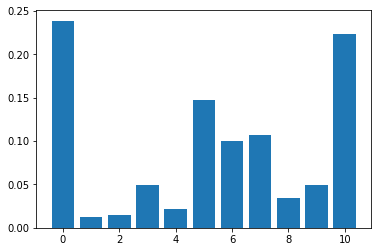

In [445]:
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.04865
Feature: 1, Score: 0.00466
Feature: 2, Score: 0.00547
Feature: 3, Score: 0.00670
Feature: 4, Score: 0.00587
Feature: 5, Score: 0.01681
Feature: 6, Score: 0.08053
Feature: 7, Score: 0.04770
Feature: 8, Score: 0.20449
Feature: 9, Score: 0.09627
Feature: 10, Score: 0.48284


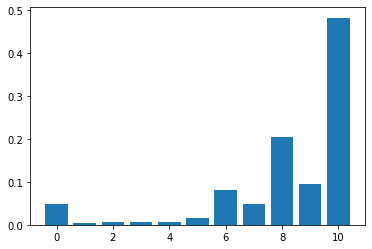

In [446]:
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.06104
Feature: 1, Score: 0.00415
Feature: 2, Score: 0.00552
Feature: 3, Score: 0.00513
Feature: 4, Score: 0.00643
Feature: 5, Score: 0.01398
Feature: 6, Score: 0.06425
Feature: 7, Score: 0.04425
Feature: 8, Score: 0.18711
Feature: 9, Score: 0.09239
Feature: 10, Score: 0.51575


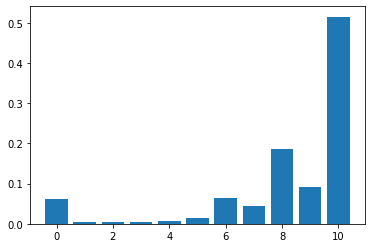

In [447]:
importance = dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

It seems the most important features includes city_development_index, experience, last new job, and education level. XGBoost also perceive relevent experience as extremely important.

If we see some of the table contents, we see that the wrongly predicted entries have different indicators based on the important columns. Like we see on the first record, the city_development_index and relevent experience is mostly alike with people who are not looking for jobs, but the education level is at 3 (graduate) and he still have a little experience which is alike to people who still look for jobs. Most of the records displayed have these patterns (mixed signals) so we concluded that most of the wrong prediction is because the entries do not have a mixed pattern.